# Project: Jigsaw Unintended Bias in Toxicity Classification
### Kaggle Challenge: Detect toxicity across a diverse range of conversations

### Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

#####When the Conversation AI team first built toxicity models, they found that the models incorrectly learned to associate the names of frequently attacked identities with toxicity. Models predicted a high likelihood of toxicity for comments containing those identities (e.g. "gay"), even when those comments were not actually toxic (such as "I am a gay woman"). This happens because training data was pulled from available sources where unfortunately, certain identities are overwhelmingly referred to in offensive ways. Training a model from data with these imbalances risks simply mirroring those biases back to users.

In this Project (originally a challenge from Kaggle), we build a simple LSTM model that recognizes toxicity and minimizes this type of unintended bias with respect to mentions of identities. We use a dataset labeled for "identity mentions" and "toxicity" from datascience challenge website "Kaggle". We train the LSTM model by 80% of dataset, validate the model by 20% of dataset, and then predict the toxicity on test data. This simple LSTM model gives an prediction accuracy of 0.95 and AUC of 0.96 on validation dataset, which are good enough considering its relatively simple structure.




#### Reference: 
#### https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/description
#### https://www.kaggle.com/thousandvoices/simple-lstm/output#data

# Import Libraries
####1. import numpy, pandas.
####2. import keras: Model, layers, optimizer and preprocessing
####3. import sklearn for splitting train and test datasets, and calculate AUC



In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.preprocessing import text, sequence
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Mounting Google Drive

In [2]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
print(os.path.abspath('.'))
root_path = '/content/gdrive/My Drive/Colab_SMDL/' 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content


# Download and unzip datasets from Kaggle




In [0]:
import urllib.request
from zipfile import ZipFile

data_path = root_path + 'data/jigsaw-unintended-bias-in-toxicity-classification.zip'

print('Beginning file download from Kaggle...')

url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/12500/868467/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1579875527&Signature=s1y7zX9%2B635HBo11YBRogD%2B4dRe98%2BU%2B2LtelJdoZHKpCEcQF9E8t3QGec1TIIpD9b758YUqqFfqoCRZ95D2IwYWoBVIraJV4IFCp5U10f1d6EXo4IOTyqh2vgKZbQxLxMNfkD7aX5Dc8PbMWmhAcFQ%2F7P0cl6drkcdyCqbvxVSoBIxTBvp3gfG2K4ujG3SCR9u%2BO0wvMGFFwQodPsBY%2F5e9OyVOLQxGaNPEO9PZzVOiNEbrFndiy7DbZGfOxW%2FVOeqRjg%2BcYsfS3KZhZO6ndiwxykYxQ9MkJHI1qphUlSr142MQAwyPWEnTROk4offCJzdefbGJ8a7pfhTXJIQwuA%3D%3D&response-content-disposition=attachment%3B+filename%3Djigsaw-unintended-bias-in-toxicity-classification.zip'
urllib.request.urlretrieve(url, data_path)


with ZipFile(data_path, 'r') as zip:
  zip.printdir()

  print("extract all the file now")
  zip.extractall(path = root_path + 'data/')
  print("done")

Beginning file download from Kaggle...
File Name                                             Modified             Size
identity_individual_annotations.csv            2019-12-16 00:24:46    106388260
sample_submission.csv                          2019-12-16 00:24:52      1167854
test.csv                                       2019-12-16 00:24:52     29925195
test_private_expanded.csv                      2019-12-16 00:24:54     44107259
test_public_expanded.csv                       2019-12-16 00:24:58     44336246
toxicity_individual_annotations.csv            2019-12-16 00:25:02    417648663
train.csv                                      2019-12-16 00:25:28    816211476
extract all the file now
done


# Download and unzip pretrained Glove vocabulary embedding

In [0]:
embedding_path = root_path + 'emb/glove.840B.300d.zip'

print('Beginning file download from Glove...')

url2 = 'http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip'
urllib.request.urlretrieve(url2, embedding_path)

print('Start to unzip files')

with ZipFile(embedding_path, 'r') as zip:
  zip.printdir()

  print("extract all the file now")
  zip.extractall(path = root_path + 'emb/')
  print("done")

# Define global variables

In [0]:
# keep most frequent 100,000 words apear in the comments from training set
MAX_FEATURES = 100000

# set the max length of input sequence, i.e., the length of  words in each comments
MAX_LEN = 220

# define feature and labels columns in datasets
TEXT_COLUMN = "comment_text"
TARGET_COLUMN = "target"
AUX_TARGETS_COLUMNS = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']

# define the charater filter in tokenizer
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'

# batch size when training LSTM moder
BATCH_SIZE = 512

# output units(vector of hidden state) of LSTM hidden layer
LSTM_UNITS = 128

# units of dense layers following LSTM layers
DENSE_HIDDEN_UNITS = LSTM_UNITS * 4

# file path for pretrained embedding model glove
EMBEDDING_FILE_PATH = root_path + 'emb/glove.840B.300d.txt'

EPOCHS = 3




# Tool functions to load embedding weights



In [0]:
# string 'word' and tuple of strings 'args' as arguments
# return word and ndarray(dtype = float)
def get_coefs(word, *args):
  return word, np.asarray(args, dtype = 'float32')


# function with path of Glove weights txt file as arguments, 
# return the dictionary of the word_embedding index
def load_embedding(emb_path):
  
  embedding_index = {}
  with open(emb_path, 'r') as f:
    for line in tqdm(f):

      # a list of string after split()
      values = line.strip().split(' ')
      word = values[0]
      coefs = np.asarray(values[1:], dtype = 'float32')
      
      # embedding_index = {'string': ndarray}
      # e.g., {'banana': [0.3 0.5 0.2 0.7 ...]}
      embedding_index[word] = coefs

  print(len(embedding_index))  
  return embedding_index


# Function to build the LSTM model

In [0]:
def build_model(embedding_matrix, num_aux_targets):
  #Input vector with 220 dimensions (220 words sequence in each comment)
  comment = Input(shape = (MAX_LEN,))

  #Input: (None, 220) output: (None, 220, 300)
  embLayer = Embedding(*embedding_matrix.shape, weights = [embedding_matrix],
                       trainable = False)(comment)

  #Dropout input units over sequence 
  #Input = output = (None, 220, 300)
  dropoutLayer = SpatialDropout1D(0.25)(embLayer)

  #Bidirectional LSTM layer
  #Output = (None, 220, 256) bidirectional with separate outputs
  LSTMLayer1 = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(dropoutLayer)

  #Bidirectional LSTM layer
  #Output = (None, 220, 256) bidirectional with separate outputs
  LSTMLayer2 = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(LSTMLayer1)

  # Max pooling the output layer of LSTM over sequence: output = (None, 256)
  # Average pooling the output layer of LSTM over sequence: output = (None, 256)
  # Concatenate the 2 pooling output w.r.t. features: output = (None, 512)
  poolingLayer = concatenate([GlobalMaxPooling1D()(LSTMLayer2), 
                              GlobalAveragePooling1D()(LSTMLayer2)])
  
  # 2 dense layers after pooling output: (None, 512)
  # Add the output of the dense layer and its input, i.e., output of pooling layer,
  # to avoid vanishing gradient problem in vertical depth
  denseLayer1 = add([poolingLayer, Dense(DENSE_HIDDEN_UNITS, activation='relu')(poolingLayer)])
  denseLayer2 = add([denseLayer1, Dense(DENSE_HIDDEN_UNITS, activation='relu')(denseLayer1)])

  # Main output to keep for prediction of the toxicity
  # Output = (None, 1)
  result = Dense(1, activation= 'sigmoid', name= 'main_output')(denseLayer2)
  
  # Aux output used to decrease the effect of identity mentions on the targert prediction
  # Output: (None, 6)
  aux_result = Dense(num_aux_targets, activation='sigmoid', name= 'aux_output')(denseLayer2)

  model = Model(inputs = comment, outputs = [result, aux_result], name = 'Simple_LSTM')

  # print model layers summary
  model.summary();

  # compile model with
  model.compile(loss = 'binary_crossentropy', 
                optimizer = Adam(clipnorm = 0.1),
                metrics=['accuracy'])
  
  return model


# Prepare train, validation and test datasets
### 0. read datasets
### 1. prepare features, labels and aux labels from datasert.
### 2. tokenize the features data.
### 3. split the train and validatin dataset according to 80-20 rule.

In [6]:
train_data_path = root_path + 'data/train.csv'
test_data_path = root_path + 'data/test.csv'

# read csv of datasets to panda dataframe 
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(train.head(1))
print(test.head(1))
print('\n')

#dataframe -> panda Series(selected column) -> ndarray
x_train = train['comment_text'].fillna('').values

print(x_train[0])
print('\n')

#label for toxicity prediction: 'target'
#aux labels for training: 6 items 
# ndarray
y_train = np.where(train['target'] >= 0.5, 1, 0)

#aux labels for training
# panda dataframe
y_aux_train = train[AUX_TARGETS_COLUMNS]

print(y_train[0])
print(y_aux_train.head(1))
print('\n')

#test data
# ndarray 
x_test = test['comment_text'].fillna('').values
print(x_test[0])


      id  target  ... identity_annotator_count  toxicity_annotator_count
0  59848     0.0  ...                        0                         4

[1 rows x 45 columns]
        id                                       comment_text
0  7097320  [ Integrity means that you pay your debts.]\n\...


This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!


0
   target  severe_toxicity  obscene  identity_attack  insult  threat
0     0.0              0.0      0.0              0.0     0.0     0.0


[ Integrity means that you pay your debts.]

Does this apply to President Trump too?


In [7]:
# initial a tokenizer to turn strings into tokens(numbers)
tokenizer = text.Tokenizer(num_words= MAX_FEATURES, filters = CHARS_TO_REMOVE, lower= False)

# fit the vocabulary appeard in the train and test data
tokenizer.fit_on_texts(list(x_train) + list(x_test))

# word_index is a dictionary maps all different words in the comments
# to different numbers
print(len(tokenizer.word_index))


# transfer word sequences to tokenized number sequences
# ndarray -> ndarray
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

print(x_train[0])
print(x_test[0])
print('\n')

# pad the number sequence to the fixed length = 220
# missing elements are filled with 0
x_train = sequence.pad_sequences(x_train, MAX_LEN)
x_test = sequence.pad_sequences(x_test, MAX_LEN)

print(x_train[0])
print(x_test[0])

424070
[85, 6, 50, 2640, 48, 13, 49, 41, 12, 108, 40, 1299, 2, 224, 23, 1165, 233, 368, 124, 223]
[16900, 352, 8, 12, 148, 40, 7312, 1015, 23, 1369, 2, 278, 55, 132]


[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 

In [8]:
print(tokenizer.index_word[1])
print(tokenizer.word_index['the'])

the
1


In [9]:
print(len(x_train))
print(len(y_train))
print(len(y_aux_train))
#split the train dataset into train and validation dataset
x_train, x_validation, y_train, y_validation, y_aux_train, y_aux_validation = train_test_split(x_train,
                                                                                               y_train,
                                                                                               y_aux_train,
                                                                                               test_size = 0.2,
                                                                                               random_state = 1)

1804874
1804874
1804874


In [10]:
print(len(x_train))
print(len(x_validation))
print(len(y_train))
print(len(y_validation))
print(len(y_aux_train))
print(len(y_aux_validation))
print(x_train[0])

1443899
360975
1443899
360975
1443899
360975
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0 10358    13  5354     6     1  8475  5299   378
   318     5   233   323    20   113  1774     3   360  4694    18  7744
   208 10358     3    29     1   268    33    29  1293    14    15   313
  9175

# Prepare the embedding matrix from pretrained word embedding model

In [11]:
#initial the embedding_matrix with shape (409328, 300) 
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))

embedding_index = load_embedding(EMBEDDING_FILE_PATH)

for word, i in tokenizer.word_index.items():
  try:
    embedding_matrix[i] = embedding_index[word]
  except KeyError:
    pass

print(embedding_matrix.shape)

2196017it [02:50, 12913.02it/s]


2196007
(424071, 300)


# Train the LSTM model and validate it

In [12]:
model = build_model(embedding_matrix, y_aux_train.shape[-1])











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "Simple_LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 220)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 220, 300)     127221300   input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 220, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 220, 256)     440320   

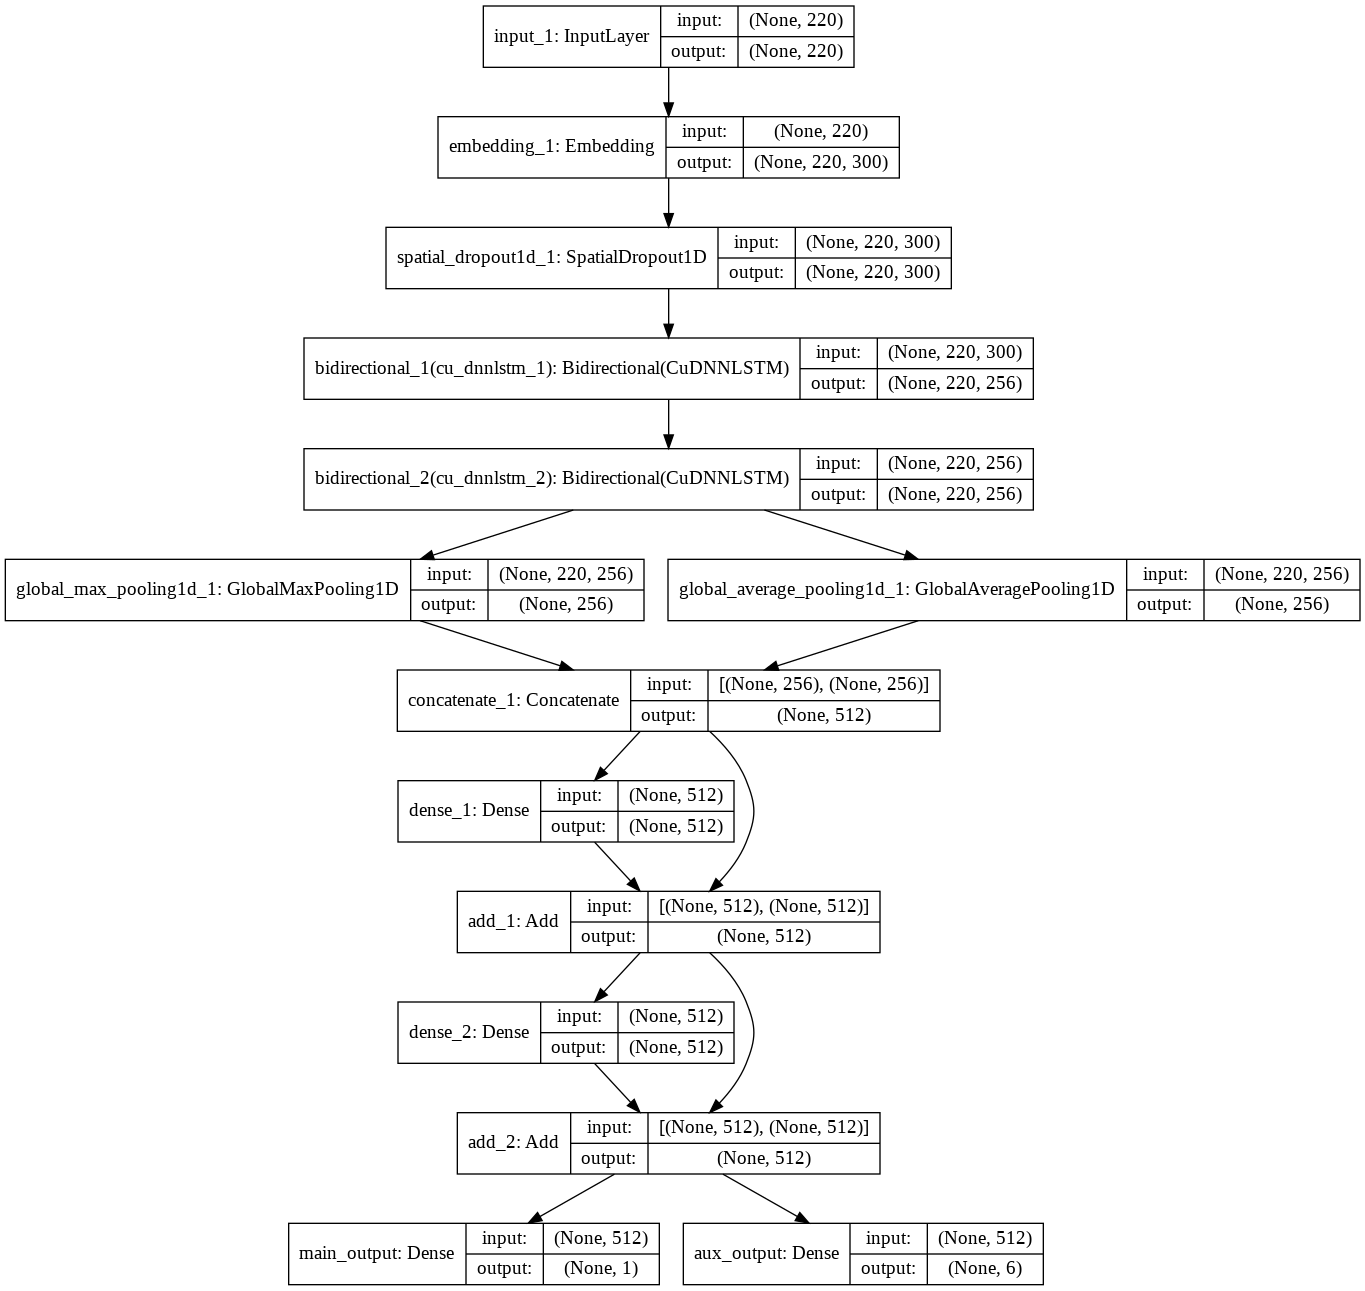

In [42]:
from keras.utils import plot_model
plot_model(model, 'Toxicity_model.png', show_shapes = True)

In [13]:
history = model.fit(x_train, 
                    [y_train, y_aux_train], 
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS, 
                    callbacks = [LearningRateScheduler(lambda epoch: 1e-3 * (0.6 ** epoch), verbose = 1)]
                    )



Epoch 1/3

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1443899/1443899 [==============================] - 745s 516us/step - loss: 0.2471 - main_output_loss: 0.1376 - aux_output_loss: 0.1095 - main_output_acc: 0.9466 - aux_output_acc: 0.8544
Epoch 2/3

Epoch 00002: LearningRateScheduler setting learning rate to 0.0006.
1443899/1443899 [==============================] - 743s 515us/step - loss: 0.2229 - main_output_loss: 0.1188 - aux_output_loss: 0.1041 - main_output_acc: 0.9527 - aux_output_acc: 0.8547
Epoch 3/3

Epoch 00003: LearningRateScheduler setting learning rate to 0.00035999999999999997.
1443899/1443899 [==============================] - 743s 515us/step - loss: 0.2161 - main_output_loss: 0.1131 - aux_output_loss: 0.1030 - main_output_acc: 0.9545 - aux_output_acc: 0.8548


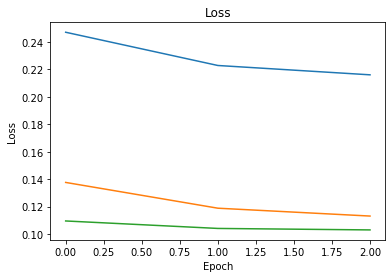

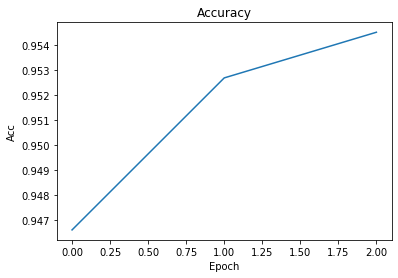

In [14]:
#plot loss and accuracy history

plt.plot(history.history['loss'])
plt.plot(history.history['main_output_loss'])
plt.plot(history.history['aux_output_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['main_output_acc'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show()

In [15]:
validation = model.evaluate(x_validation, [y_validation, y_aux_validation], verbose = 1)

360975/360975 [==============================] - 195s 539us/step


In [16]:
# obtain comparable accuracy of target prediction on validation set
print(model.metrics_names[3:])
print(validation[3:])

['main_output_acc', 'aux_output_acc']
[0.9530216774014821, 0.8557273239990013]


# Plot ROC-AUC and confusion matrix for validation data

In [17]:
# 1d ndarray prediction of toxicity
val_pred = model.predict(x_validation, batch_size = 2048)[0].flatten()
print(val_pred[1:7])
# 
def cal_AUC(y_label, y_pred):
  try:
    return metrics.roc_auc_score(y_label, y_pred)
  except ValueError:
    return np.nan

print('AUC of validation sets: ', cal_AUC(y_validation, val_pred))

[9.2021811e-01 5.2723289e-04 9.9914968e-03 7.8329444e-04 1.7339289e-03
 1.3367653e-02]
AUC of validation sets:  0.965045230464008


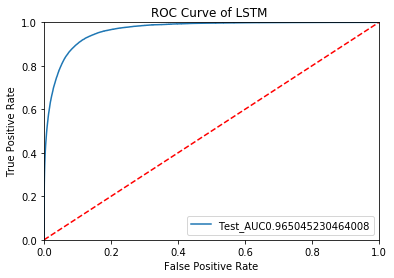

In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr_test, tpr_test, threshold_test = roc_curve(y_validation, val_pred)
roc_auc_test = auc(fpr_test, tpr_test)

plt.plot(fpr_test, tpr_test, label = "Test_AUC"+str(auc(fpr_test, tpr_test)))
plt.legend(loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of LSTM ')
plt.show()

In [0]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

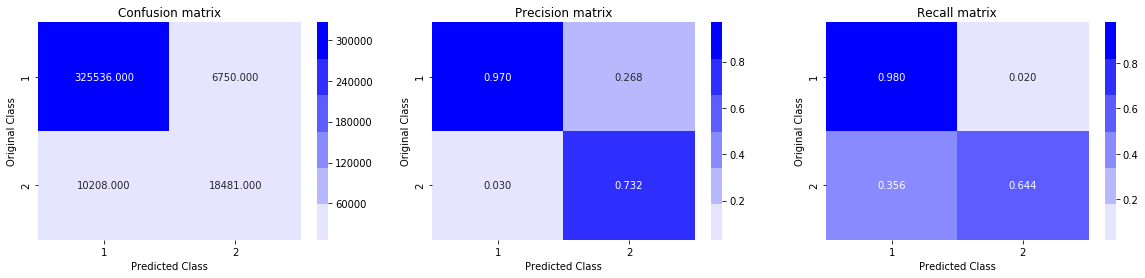

In [40]:
plot_confusion_matrix(y_validation, val_pred.round())

# Examples of prediction
###1. nontoxic with uindented bias
###2. toxic with identity attack 

In [18]:
x_example = np.array(["Continue to stand strong LGBT community. Yes, indeed, you'll overcome and you have.", 
                      "I am a proud gay man",
                      "Gay people are only wasting our tax, disgraceful!"])

print('example comments: ', '\n', x_example)

x_example = tokenizer.texts_to_sequences(x_example)

x_example = sequence.pad_sequences(x_example, MAX_LEN)

predict_example = model.predict(x_example)[0].flatten()

print('predicted toxicity: ', predict_example)



example comments:  
 ["Continue to stand strong LGBT community. Yes, indeed, you'll overcome and you have."
 'I am a proud gay man'
 'Gay people are only wasting our tax, disgraceful!']
predicted toxicity:  [0.06224791 0.37749317 0.86016333]


# Others

In [19]:
print(y_aux_validation.iloc[2]['identity_attack'])
print(y_aux_validation.shape[0])

0.0
360975


In [0]:
def find_index(df, target, identity_att):
  
  index = -1
  for i in range(df.shape[0]):
    if (df.iloc[i]['target'] >= target and 
        df.iloc[i]['female'] > identity_att):
      index = i
      break

  return i

In [21]:
# Find a comments in validation sets that is 
# intended(identity > 0.8) and toxic(target > 0.8)
idx_tox_id = find_index(train, 0.0, 0.5)
print('index: ', idx_tox_id)
print('toxic: ', train.iloc[idx_tox_id]['target'])
print('identity: ', train.iloc[idx_tox_id]['female'])
print('toxic comment: ', train.iloc[idx_tox_ind][TEXT_COLUMN])
#text = tokenizer.sequences_to_texts([x_validation[idx_tox_ind]])



index:  34
toxic:  0.8307692307692307
identity:  1.0


NameError: ignored